In [ ]:
!pip install optuna
!pip install optuna-integration[xgboost]
!pip install openml

In [ ]:
!pip install openml

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


Pobranie potrzebnych pakietów


In [ ]:
import openml
import optuna
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from scipy.stats import uniform
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline # moduł pipeline
from sklearn.impute import SimpleImputer # moduł imputacji braków danych
from sklearn.preprocessing import OneHotEncoder, StandardScaler # moduł przetwarzania danych
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # modele lasu losowego
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score # metryki
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from plotly.io import show
np.set_printoptions(suppress=True)

Pipeline do preprocessingu

In [ ]:
## Obsługa zmiennych numerycznych
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('scale', StandardScaler())
])

## Obsługa zmiennych kategorycznych
cat_pipeline= Pipeline(steps = [
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])


col_trans = ColumnTransformer(
    transformers=[
        (
            "numeric_preprocessing",
            num_pipeline,
            make_column_selector(dtype_include=np.number),
        ),
        (
            "categorical_preprocessing",
            cat_pipeline,
            make_column_selector(dtype_include='category'),
        ),
    ],
    remainder="passthrough", ## jak procesowane sa kolumny, ktore nie zostaly wybrane w liscie operacji
)

## Pipeline

model_pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

Wybranie 15 zbiorów danych z openml

In [ ]:
# Wybór zbioru danych przed ID
idd=[29, 1063, 37, 40702, 966, 31, 44, 1489, 1462, 470, 15, 784, 1464, 3, 719]


Import danych

In [ ]:
X_all = []
y_all = []
X_all_trcv = []
for key in idd:
  dataset = openml.datasets.get_dataset(key)
  X_temp, y_temp, _, _ = dataset.get_data(target=dataset.default_target_attribute)
  le = LabelEncoder()
  y_all.append(le.fit_transform(y_temp))
  X_all.append(X_temp)
  X_all_trcv.append(model_pipeline.fit_transform(X_temp, le.fit_transform(y_temp)))

Wybieramy zbiory, na których sprawdzimy liczbę potrzebnych iteracji dla RandomSearch


In [ ]:
X_1, y_1 = X_all_trcv[0], y_all[0]
X_2, y_2 = X_all_trcv[5], y_all[5]
X_3, y_3 = X_all_trcv[9], y_all[9]

In [ ]:
n_iter=[4, 6, 8, 10, 15, 20, 35, 50, 75, 100]
auc_1=np.array([])
auc_2=np.array([])
auc_3=np.array([])
for i in n_iter:
  regr = LogisticRegression(
          penalty='elasticnet',
          solver='saga',
          max_iter=50000,
          random_state=0
            )
  distributions = dict(l1_ratio=uniform(),
                      C=uniform(scale=10))
  regr_param=RandomizedSearchCV(regr, distributions, n_iter=i, scoring="roc_auc", cv=3, random_state=0)

  best_model_data=regr_param.fit(X_1, y_1)
  auc_1=np.append(auc_1, best_model_data.best_score_)

  best_model_data=regr_param.fit(X_2, y_2)
  auc_2=np.append(auc_2, best_model_data.best_score_)

  best_model_data=regr_param.fit(X_3, y_3)
  auc_3=np.append(auc_3, best_model_data.best_score_)

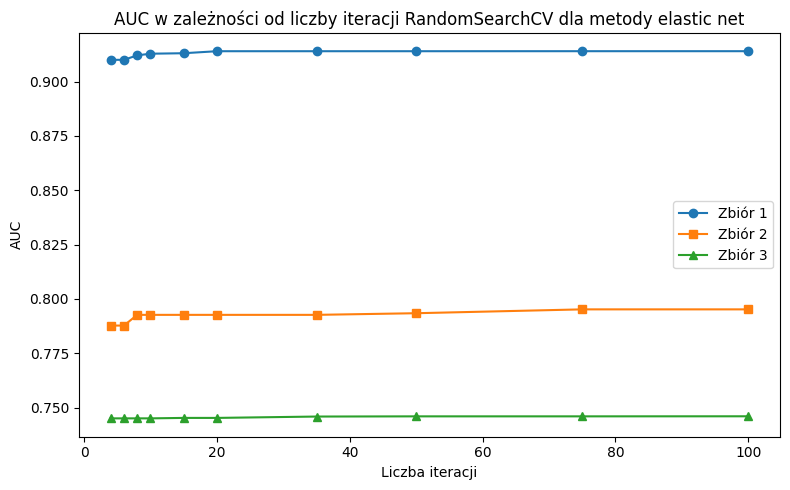

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(n_iter, auc_1, label='Zbiór 1', marker='o')
plt.plot(n_iter, auc_2, label='Zbiór 2', marker='s')
plt.plot(n_iter, auc_3, label='Zbiór 3', marker='^')

plt.title('AUC w zależności od liczby iteracji RandomSearchCV dla metody elastic net')
plt.xlabel('Liczba iteracji')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
n_iter=[4, 6, 8, 10, 15, 20, 35, 50, 75, 100]
auc_1=np.array([])
auc_2=np.array([])
auc_3=np.array([])
best_params=[]
for i in n_iter:
  knn = KNeighborsClassifier()

  distributions = dict(n_neighbors= list(range(1, 41)),
                     weights=["uniform", "distance"],
                    p=uniform(loc=1, scale=5))
  regr_param=RandomizedSearchCV(knn, distributions, n_iter=i, scoring="roc_auc", cv=3, random_state=0)

  best_model_data=regr_param.fit(X_1, y_1)
  auc_1=np.append(auc_1, best_model_data.best_score_)

  best_model_data=regr_param.fit(X_2, y_2)
  auc_2=np.append(auc_2, best_model_data.best_score_)


  best_model_data=regr_param.fit(X_3, y_3)
  auc_3=np.append(auc_3, best_model_data.best_score_)

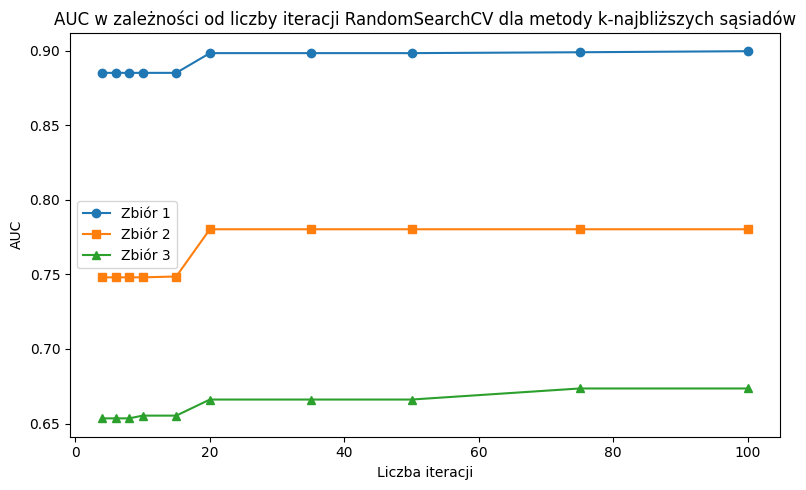

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(n_iter, auc_1, label='Zbiór 1', marker='o')
plt.plot(n_iter, auc_2, label='Zbiór 2', marker='s')
plt.plot(n_iter, auc_3, label='Zbiór 3', marker='^')

plt.title('AUC w zależności od liczby iteracji RandomSearchCV dla metody k-najbliższych sąsiadów')
plt.xlabel('Liczba iteracji')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
n_iter=[4, 6, 8, 10, 15, 20, 35, 50, 75, 100]
auc_1=np.array([])
auc_2=np.array([])
auc_3=np.array([])
for i in n_iter:
  xgb = XGBClassifier(random_state=0)

  distributions=dict(learning_rate=uniform(), n_estimators=list(range(10,5000, 1)), subsample=uniform(), gamma=uniform(), reg_alpha=uniform(scale=10), reg_lambda=uniform(scale=40),
                   max_depth=list(range(1, 20, 1)))

  regr_param=RandomizedSearchCV(xgb, distributions, n_iter=i, scoring="roc_auc", cv=3  , random_state=0)

  best_model_data=regr_param.fit(X_1, y_1)
  auc_1=np.append(auc_1, best_model_data.best_score_)

  best_model_data=regr_param.fit(X_2, y_2)
  auc_2=np.append(auc_2, best_model_data.best_score_)

  best_model_data=regr_param.fit(X_3, y_3)
  auc_3=np.append(auc_3, best_model_data.best_score_)

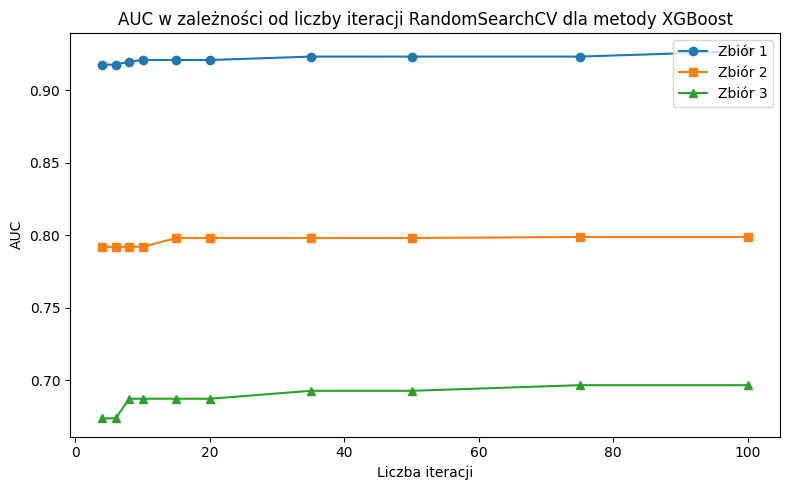

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(n_iter, auc_1, label='Zbiór 1', marker='o')
plt.plot(n_iter, auc_2, label='Zbiór 2', marker='s')
plt.plot(n_iter, auc_3, label='Zbiór 3', marker='^')

plt.title('AUC w zależności od liczby iteracji RandomSearchCV dla metody XGBoost')
plt.xlabel('Liczba iteracji')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

Zdefiniowanie odpowiednich funkcji w optunie

In [ ]:
### tu zaczyna się optunowanie

### objectivy - id przyjmowane dla wygody, w study optimize trzeba używać lambda trial zamiast funkcji objective


def objective_reglog(trial, id):
  X, y = X_all_trcv[id], y_all[id]
  reg_c = trial.suggest_float(name="C",low=0,high=10)
  reg_l1 = trial.suggest_float(name="l1_ratio",low=0,high=1)
  params = {
      "C": reg_c,
      "l1_ratio": reg_l1
  }
  regr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=50000,
    random_state=0,
    **params
  )


  score = cross_val_score(regr, X, y, cv=3, scoring="roc_auc")
  return score.mean()

def objective_knn(trial, id):
  X, y = X_all_trcv[id], y_all[id]
  knn_n = trial.suggest_int("n_neighbors", 1, 40)
  knn_p = trial.suggest_float("p", 1, 5)
  knn_weights = trial.suggest_categorical("weights", ["distance", "uniform"])
  params = {
      "n_neighbors": knn_n,
      "p": knn_p,
      "weights": knn_weights
  }
  knn = KNeighborsClassifier(
    **params
  )

  ### pruning- aby liczyło się mniej niż całe moje życie
  #pruneability = [0.05, 0.1, 0.25, 0.5]

  #for step in range(len(pruneability)):
  #  X_part, _, y_part, _ = train_test_split(X, y, train_size=pruneability[step])
  #  score_part = cross_val_score(knn, X_part, y_part, cv=3, scoring="roc_auc")
  #  trial.report(score_part.mean(), step)

  #  if trial.should_prune():
  #      raise optuna.TrialPruned()

  score = cross_val_score(knn, X, y, cv=3, scoring="roc_auc")
  return score.mean()


def objective_xgb(trial, id):
  X, y = X_all_trcv[id], y_all[id]
  xgb_lr = trial.suggest_float(name="learning_rate", low=0, high=1)
  xgb_nest = trial.suggest_int("n_estimators", 10, 5000)
  xgb_subsample = trial.suggest_float(name="subsample", low=0, high=1)
  xgb_l1 = trial.suggest_float(name="reg_alpha", low=0, high=10)
  xgb_l2 = trial.suggest_float(name="reg_lambda", low=0, high=40)
  xgb_depth = trial.suggest_int("max_depth", 1, 20)
  xgb_gamma = trial.suggest_float(name="gamma", low=0, high=1)
  params = {
    "learning_rate": xgb_lr,
    "n_estimators": xgb_nest,
    "subsample": xgb_subsample,
    "max_depth": xgb_depth,
    "gamma": xgb_gamma,
    "reg_alpha": xgb_l1,
    "reg_lambda": xgb_l2,
    "eval_metric": "auc"
  }
  xgb = XGBClassifier(
      **params
  )

  #pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
  score = cross_val_score(xgb, X, y, cv=3, scoring="roc_auc")
  return score.mean()

Sprawdzamy potrzebną liczbę iteracji dla optuny

In [ ]:
study_reglog = optuna.create_study(direction="maximize")

study_reglog.optimize(lambda trial:objective_reglog(trial, 1), n_trials=1000)

print("Optimization finished.")
print(f"Number of finished trials: {len(study_reglog.trials)}")

print("Best trial:")
best_trial = study_reglog.best_trial
print(f"  Value (Accuracy): {best_trial.value:.4f}")

In [ ]:
# Plot the parameter relationship as contour plot in a study.
#contour_tpe = optuna.visualization.plot_contour(study_xgb, params=["kernel", "C"])
#show(contour_tpe)

# Plot optimization history of all trials in a study.
history_tpe = optuna.visualization.plot_optimization_history(study_reglog)
show(history_tpe)

# Plot the high-dimensional parameter relationships in a study.
#parallel_tpe = optuna.visualization.plot_parallel_coordinate(study_xgb)
#show(parallel_tpe)

In [ ]:
study_knn= optuna.create_study(direction="maximize")

study_knn.optimize(lambda trial:objective_knn(trial, 1), n_trials=1000)

print("Optimization finished.")
print(f"Number of finished trials: {len(study_knn.trials)}")

print("Best trial:")
best_trial = study_knn.best_trial
print(f"  Value (Accuracy): {best_trial.value:.4f}")

In [ ]:
# Plot the parameter relationship as contour plot in a study.
#contour_tpe = optuna.visualization.plot_contour(study_xgb, params=["kernel", "C"])
#show(contour_tpe)

# Plot optimization history of all trials in a study.
history_tpe = optuna.visualization.plot_optimization_history(study_knn)
show(history_tpe)

# Plot the high-dimensional parameter relationships in a study.
#parallel_tpe = optuna.visualization.plot_parallel_coordinate(study_xgb)
#show(parallel_tpe)

In [ ]:
study_xgb = optuna.create_study(direction="maximize")

study_xgb.optimize(lambda trial:objective_xgb(trial, 1), n_trials=1000)

print("Optimization finished.")
print(f"Number of finished trials: {len(study_xgb.trials)}")

print("Best trial:")
best_trial = study_xgb.best_trial
print(f"  Value (Accuracy): {best_trial.value:.4f}")

[I 2025-11-15 20:51:53,315] A new study created in memory with name: no-name-ec3850e0-953f-4051-ad04-49f90260fa9f
[I 2025-11-15 20:51:58,568] Trial 0 finished with value: 0.7768179245423537 and parameters: {'learning_rate': 0.07820355943128032, 'n_estimators': 4409, 'subsample': 0.7527459015176818, 'reg_alpha': 1.8181744834324864, 'reg_lambda': 4.830983352322282, 'max_depth': 11, 'gamma': 0.1889510126933165}. Best is trial 0 with value: 0.7768179245423537.
[I 2025-11-15 20:51:59,118] Trial 1 finished with value: 0.8241769179549389 and parameters: {'learning_rate': 0.34725631156273673, 'n_estimators': 964, 'subsample': 0.40970985907882196, 'reg_alpha': 4.595624455366747, 'reg_lambda': 39.77024348274539, 'max_depth': 15, 'gamma': 0.5871440347044335}. Best is trial 1 with value: 0.8241769179549389.
[I 2025-11-15 20:52:00,142] Trial 2 finished with value: 0.8244160158415711 and parameters: {'learning_rate': 0.027921573923173182, 'n_estimators': 1657, 'subsample': 0.5756078660165075, 'reg_a

Optimization finished.
Number of finished trials: 1000
Best trial:
  Value (Accuracy): 0.8337


In [ ]:
# Plot the parameter relationship as contour plot in a study.
#contour_tpe = optuna.visualization.plot_contour(study_xgb, params=["kernel", "C"])
#show(contour_tpe)

# Plot optimization history of all trials in a study.
history_tpe = optuna.visualization.plot_optimization_history(study_xgb)
show(history_tpe)

# Plot the high-dimensional parameter relationships in a study.
#parallel_tpe = optuna.visualization.plot_parallel_coordinate(study_xgb)
#show(parallel_tpe)

Poszukiwanie optymalnych hiperparametrów za pomocą optuny

In [ ]:
params_reglog = [None]*len(idd)
auc_reglog = [None]*len(idd)

for i in range(len(idd)):
  ### optuna - regresja logistyczna
  study_reglog = optuna.create_study(direction="maximize")

  study_reglog.optimize(lambda trial:objective_reglog(trial, i), n_trials=300)

  print("Optimization finished.")
  print(f"Number of finished trials: {len(study_reglog.trials)}")

  print("Best trial:")
  best_trial = study_reglog.best_trial
  print(f"  Value (AUC): {best_trial.value:.4f}")
  auc_reglog[i] = round(best_trial.value,4)
  params_reglog[i] = study_reglog.best_params

[I 2025-11-15 03:58:32,247] A new study created in memory with name: no-name-d0416e9b-f3ab-43ee-949d-c4f27aef2e0d
[I 2025-11-15 03:58:33,965] Trial 0 finished with value: 0.9088792722275185 and parameters: {'C': 8.750649983133084, 'l1_ratio': 0.0113813439332906}. Best is trial 0 with value: 0.9088792722275185.
[I 2025-11-15 03:58:37,213] Trial 1 finished with value: 0.9087521537342992 and parameters: {'C': 8.573983397392777, 'l1_ratio': 0.6978838419758121}. Best is trial 0 with value: 0.9088792722275185.
[I 2025-11-15 03:58:39,190] Trial 2 finished with value: 0.9089816891753643 and parameters: {'C': 7.997001727946187, 'l1_ratio': 0.7044592127712394}. Best is trial 2 with value: 0.9089816891753643.
[I 2025-11-15 03:58:40,203] Trial 3 finished with value: 0.9116341854617009 and parameters: {'C': 1.7062100639692956, 'l1_ratio': 0.35161331047204913}. Best is trial 3 with value: 0.9116341854617009.
[I 2025-11-15 03:58:42,672] Trial 4 finished with value: 0.9105642236588466 and parameters: 

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.9158


[I 2025-11-15 04:02:30,345] Trial 0 finished with value: 0.7849027886041754 and parameters: {'C': 6.140792090569921, 'l1_ratio': 0.10488680120196803}. Best is trial 0 with value: 0.7849027886041754.
[I 2025-11-15 04:02:32,667] Trial 1 finished with value: 0.7836080755823223 and parameters: {'C': 9.88259475046144, 'l1_ratio': 0.6932500628589995}. Best is trial 0 with value: 0.7849027886041754.
[I 2025-11-15 04:02:34,705] Trial 2 finished with value: 0.7915091253429279 and parameters: {'C': 3.7384695328120343, 'l1_ratio': 0.8897452959932219}. Best is trial 2 with value: 0.7915091253429279.
[I 2025-11-15 04:02:37,762] Trial 3 finished with value: 0.7843896242564264 and parameters: {'C': 7.821879595053826, 'l1_ratio': 0.5777348833048582}. Best is trial 2 with value: 0.7915091253429279.
[I 2025-11-15 04:02:39,348] Trial 4 finished with value: 0.792605391187395 and parameters: {'C': 3.0891836101683188, 'l1_ratio': 0.6683065907197117}. Best is trial 4 with value: 0.792605391187395.
[I 2025-11

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.8238


[I 2025-11-15 04:06:20,051] Trial 8 finished with value: 0.8326531960821524 and parameters: {'C': 7.981446829558079, 'l1_ratio': 0.7902813418569558}. Best is trial 3 with value: 0.8326981657820589.
[I 2025-11-15 04:06:20,073] Trial 9 finished with value: 0.832518749334056 and parameters: {'C': 5.905339269879754, 'l1_ratio': 0.2783207327747622}. Best is trial 3 with value: 0.8326981657820589.
[I 2025-11-15 04:06:20,099] Trial 10 finished with value: 0.8325640657976798 and parameters: {'C': 3.256801564994447, 'l1_ratio': 0.9885915216437816}. Best is trial 3 with value: 0.8326981657820589.
[I 2025-11-15 04:06:20,124] Trial 11 finished with value: 0.8326310002019636 and parameters: {'C': 5.683263004255371, 'l1_ratio': 0.8900590353245244}. Best is trial 3 with value: 0.8326981657820589.
[I 2025-11-15 04:06:20,151] Trial 12 finished with value: 0.832563487858151 and parameters: {'C': 9.923345290748369, 'l1_ratio': 0.7592162466089843}. Best is trial 3 with value: 0.8326981657820589.
[I 2025-1

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.8327


[I 2025-11-15 04:06:29,479] Trial 1 finished with value: 0.7412937991719796 and parameters: {'C': 4.824713284850798, 'l1_ratio': 0.43260813201228754}. Best is trial 0 with value: 0.7516398514578565.
[I 2025-11-15 04:06:29,718] Trial 2 finished with value: 0.7361338939576942 and parameters: {'C': 9.37760634215903, 'l1_ratio': 0.22363401305737451}. Best is trial 0 with value: 0.7516398514578565.
[I 2025-11-15 04:06:29,889] Trial 3 finished with value: 0.7363404643139093 and parameters: {'C': 6.874589428323189, 'l1_ratio': 0.8153348021024556}. Best is trial 0 with value: 0.7516398514578565.
[I 2025-11-15 04:06:30,076] Trial 4 finished with value: 0.7423740627120535 and parameters: {'C': 4.557961408311993, 'l1_ratio': 0.5150686622010958}. Best is trial 0 with value: 0.7516398514578565.
[I 2025-11-15 04:06:30,307] Trial 5 finished with value: 0.7372182402645229 and parameters: {'C': 8.656048515822079, 'l1_ratio': 0.029767179072130445}. Best is trial 0 with value: 0.7516398514578565.
[I 2025

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.7676


[I 2025-11-15 04:07:05,522] Trial 0 finished with value: 0.9641736329179871 and parameters: {'C': 4.738006443208387, 'l1_ratio': 0.571506248655375}. Best is trial 0 with value: 0.9641736329179871.
[I 2025-11-15 04:07:06,377] Trial 1 finished with value: 0.9648360839869422 and parameters: {'C': 1.6613606728547736, 'l1_ratio': 0.7005204853677784}. Best is trial 1 with value: 0.9648360839869422.
[I 2025-11-15 04:07:07,160] Trial 2 finished with value: 0.9651711331928134 and parameters: {'C': 1.8163294799047858, 'l1_ratio': 0.5060733269211686}. Best is trial 2 with value: 0.9651711331928134.
[I 2025-11-15 04:07:08,109] Trial 3 finished with value: 0.9645588678109004 and parameters: {'C': 1.7514799185191054, 'l1_ratio': 0.8102121143744119}. Best is trial 2 with value: 0.9651711331928134.
[I 2025-11-15 04:07:09,188] Trial 4 finished with value: 0.9644092666676226 and parameters: {'C': 2.8365077432204853, 'l1_ratio': 0.6291082319340332}. Best is trial 2 with value: 0.9651711331928134.
[I 2025

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.9658


[I 2025-11-15 04:10:34,853] Trial 0 finished with value: 0.7882124646931513 and parameters: {'C': 3.4217049041190117, 'l1_ratio': 0.30390399531854806}. Best is trial 0 with value: 0.7882124646931513.
[I 2025-11-15 04:10:35,514] Trial 1 finished with value: 0.7869266840296882 and parameters: {'C': 7.219466858160155, 'l1_ratio': 0.4609874327161243}. Best is trial 0 with value: 0.7882124646931513.
[I 2025-11-15 04:10:36,269] Trial 2 finished with value: 0.7874700732426055 and parameters: {'C': 4.228636884199741, 'l1_ratio': 0.004783721522839568}. Best is trial 0 with value: 0.7882124646931513.
[I 2025-11-15 04:10:37,056] Trial 3 finished with value: 0.7883261802575108 and parameters: {'C': 3.1915591638022445, 'l1_ratio': 0.5426774950260131}. Best is trial 3 with value: 0.7883261802575108.
[I 2025-11-15 04:10:38,035] Trial 4 finished with value: 0.7870696844087401 and parameters: {'C': 7.110760653305389, 'l1_ratio': 0.37512494505781235}. Best is trial 3 with value: 0.7883261802575108.
[I 2

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.7957


[I 2025-11-15 04:12:38,827] Trial 0 finished with value: 0.9526399023837842 and parameters: {'C': 6.195355261785167, 'l1_ratio': 0.7626596767417315}. Best is trial 0 with value: 0.9526399023837842.
[I 2025-11-15 04:13:22,591] Trial 1 finished with value: 0.9530042227087202 and parameters: {'C': 1.8487929406470849, 'l1_ratio': 0.9452851342521458}. Best is trial 1 with value: 0.9530042227087202.
[I 2025-11-15 04:14:07,142] Trial 2 finished with value: 0.9527718263817008 and parameters: {'C': 9.422220039648199, 'l1_ratio': 0.1644478720060798}. Best is trial 1 with value: 0.9530042227087202.
[I 2025-11-15 04:14:22,824] Trial 3 finished with value: 0.9558036308018486 and parameters: {'C': 0.40070579215786384, 'l1_ratio': 0.5492149573659649}. Best is trial 3 with value: 0.9558036308018486.
[I 2025-11-15 04:14:28,304] Trial 4 finished with value: 0.9553093679478568 and parameters: {'C': 0.060261596250985594, 'l1_ratio': 0.12562454375098575}. Best is trial 3 with value: 0.9558036308018486.
[I 

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.9577


[I 2025-11-15 06:07:19,986] Trial 3 finished with value: 0.8125733016661973 and parameters: {'C': 0.9890330019119198, 'l1_ratio': 0.16299163168936148}. Best is trial 1 with value: 0.8125733073618141.
[I 2025-11-15 06:07:20,043] Trial 4 finished with value: 0.8125708270445907 and parameters: {'C': 3.4789481555347077, 'l1_ratio': 0.7662540817993567}. Best is trial 1 with value: 0.8125733073618141.
[I 2025-11-15 06:07:20,134] Trial 5 finished with value: 0.8125832104825618 and parameters: {'C': 1.0305889501883903, 'l1_ratio': 0.951701017346378}. Best is trial 5 with value: 0.8125832104825618.
[I 2025-11-15 06:07:20,188] Trial 6 finished with value: 0.8125990562363533 and parameters: {'C': 0.6061924797543261, 'l1_ratio': 0.8001352921503662}. Best is trial 6 with value: 0.8125990562363533.
[I 2025-11-15 06:07:20,244] Trial 7 finished with value: 0.8125698359011682 and parameters: {'C': 5.253637229982893, 'l1_ratio': 0.8104166832815777}. Best is trial 6 with value: 0.8125990562363533.
[I 202

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.8128


[I 2025-11-15 06:09:30,082] Trial 0 finished with value: 0.4496641887735673 and parameters: {'C': 2.0829081546153616, 'l1_ratio': 0.9291044935529276}. Best is trial 0 with value: 0.4496641887735673.
[I 2025-11-15 06:11:19,964] Trial 1 finished with value: 0.4500890390172685 and parameters: {'C': 1.615092077284549, 'l1_ratio': 0.7914001054683624}. Best is trial 1 with value: 0.4500890390172685.
[I 2025-11-15 06:13:17,427] Trial 2 finished with value: 0.44910763946770316 and parameters: {'C': 9.099824798079952, 'l1_ratio': 0.15666125906109407}. Best is trial 1 with value: 0.4500890390172685.
[I 2025-11-15 06:15:12,276] Trial 3 finished with value: 0.44906309896571556 and parameters: {'C': 8.30079052348146, 'l1_ratio': 0.5948309279784683}. Best is trial 1 with value: 0.4500890390172685.
[I 2025-11-15 06:17:07,365] Trial 4 finished with value: 0.44920054252633096 and parameters: {'C': 7.137216159068537, 'l1_ratio': 0.18640625304793335}. Best is trial 1 with value: 0.4500890390172685.
[I 20

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.5225


[I 2025-11-15 11:38:56,103] Trial 0 finished with value: 0.7457427897696354 and parameters: {'C': 5.44225552033593, 'l1_ratio': 0.19426286185088248}. Best is trial 0 with value: 0.7457427897696354.
[I 2025-11-15 11:38:56,704] Trial 1 finished with value: 0.7441270129189593 and parameters: {'C': 4.748595084114306, 'l1_ratio': 0.7532792894071786}. Best is trial 0 with value: 0.7457427897696354.
[I 2025-11-15 11:38:57,346] Trial 2 finished with value: 0.7435892939919785 and parameters: {'C': 6.306401388818772, 'l1_ratio': 0.7320122123440661}. Best is trial 0 with value: 0.7457427897696354.
[I 2025-11-15 11:38:57,837] Trial 3 finished with value: 0.7455626095894553 and parameters: {'C': 6.319234289120583, 'l1_ratio': 0.2517135245195973}. Best is trial 0 with value: 0.7457427897696354.
[I 2025-11-15 11:38:58,285] Trial 4 finished with value: 0.7387983957111475 and parameters: {'C': 2.2619626020162134, 'l1_ratio': 0.9020122993271086}. Best is trial 0 with value: 0.7457427897696354.
[I 2025-1

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.7464


[I 2025-11-15 11:41:10,766] Trial 0 finished with value: 0.8391670577801023 and parameters: {'C': 0.4161520138162067, 'l1_ratio': 0.5081748180803672}. Best is trial 0 with value: 0.8391670577801023.
[I 2025-11-15 11:41:11,252] Trial 1 finished with value: 0.8391474546932419 and parameters: {'C': 2.0756881182628737, 'l1_ratio': 0.4705969513722119}. Best is trial 0 with value: 0.8391670577801023.
[I 2025-11-15 11:41:11,727] Trial 2 finished with value: 0.8391413075757711 and parameters: {'C': 9.574001959998503, 'l1_ratio': 0.7870132418573969}. Best is trial 0 with value: 0.8391670577801023.
[I 2025-11-15 11:41:12,221] Trial 3 finished with value: 0.8391413803288194 and parameters: {'C': 9.46156257488173, 'l1_ratio': 0.7691795937228403}. Best is trial 0 with value: 0.8391670577801023.
[I 2025-11-15 11:41:12,725] Trial 4 finished with value: 0.8391441084188256 and parameters: {'C': 2.3110839524342373, 'l1_ratio': 0.002059736391548439}. Best is trial 0 with value: 0.8391670577801023.
[I 202

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.8392


[I 2025-11-15 11:42:33,530] Trial 4 finished with value: 0.3006983826927116 and parameters: {'C': 8.629762075164919, 'l1_ratio': 0.9336905036055667}. Best is trial 1 with value: 0.33656269691241336.
[I 2025-11-15 11:42:33,579] Trial 5 finished with value: 0.30799726948120143 and parameters: {'C': 5.945804796277262, 'l1_ratio': 0.8332502365451885}. Best is trial 1 with value: 0.33656269691241336.
[I 2025-11-15 11:42:33,634] Trial 6 finished with value: 0.30794475950430583 and parameters: {'C': 4.801580899010361, 'l1_ratio': 0.952579369120203}. Best is trial 1 with value: 0.33656269691241336.
[I 2025-11-15 11:42:33,670] Trial 7 finished with value: 0.31957571938668344 and parameters: {'C': 5.891115303423247, 'l1_ratio': 0.4545165726825161}. Best is trial 1 with value: 0.33656269691241336.
[I 2025-11-15 11:42:33,701] Trial 8 finished with value: 0.32621823146397816 and parameters: {'C': 1.5135251839343389, 'l1_ratio': 0.7836340838643874}. Best is trial 1 with value: 0.33656269691241336.
[

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.5850


[I 2025-11-15 11:42:43,331] Trial 7 finished with value: 0.8211685994647637 and parameters: {'C': 0.7963376699356706, 'l1_ratio': 0.328834946540577}. Best is trial 7 with value: 0.8211685994647637.
[I 2025-11-15 11:42:43,362] Trial 8 finished with value: 0.8204088611358906 and parameters: {'C': 6.735746726502475, 'l1_ratio': 0.4793852800565769}. Best is trial 7 with value: 0.8211685994647637.
[I 2025-11-15 11:42:43,386] Trial 9 finished with value: 0.8203498860144713 and parameters: {'C': 5.1802129905946, 'l1_ratio': 0.15522827524249094}. Best is trial 7 with value: 0.8211685994647637.
[I 2025-11-15 11:42:43,415] Trial 10 finished with value: 0.8213534542571117 and parameters: {'C': 0.20005497140101003, 'l1_ratio': 0.2706297936625034}. Best is trial 10 with value: 0.8213534542571117.
[I 2025-11-15 11:42:43,444] Trial 11 finished with value: 0.8212597878877986 and parameters: {'C': 0.28746499622459165, 'l1_ratio': 0.28674214473290044}. Best is trial 10 with value: 0.8213534542571117.
[I

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.8306


[I 2025-11-15 11:42:53,175] Trial 0 finished with value: 0.9830025156032881 and parameters: {'C': 6.070210028919956, 'l1_ratio': 0.202564900646233}. Best is trial 0 with value: 0.9830025156032881.
[I 2025-11-15 11:42:54,428] Trial 1 finished with value: 0.9834210028780648 and parameters: {'C': 3.7472817937297274, 'l1_ratio': 0.5680837908517204}. Best is trial 1 with value: 0.9834210028780648.
[I 2025-11-15 11:42:54,774] Trial 2 finished with value: 0.9713757918264966 and parameters: {'C': 0.7058078300094961, 'l1_ratio': 0.04840619155216341}. Best is trial 1 with value: 0.9834210028780648.
[I 2025-11-15 11:42:55,398] Trial 3 finished with value: 0.9836964080102875 and parameters: {'C': 1.9530743080414703, 'l1_ratio': 0.7908838238417907}. Best is trial 3 with value: 0.9836964080102875.
[I 2025-11-15 11:42:55,889] Trial 4 finished with value: 0.9823424506665562 and parameters: {'C': 3.8488734181038486, 'l1_ratio': 0.25017921417536426}. Best is trial 3 with value: 0.9836964080102875.
[I 20

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.9855


[I 2025-11-15 11:52:14,386] Trial 4 finished with value: 0.7395257296466973 and parameters: {'C': 7.9330693704830635, 'l1_ratio': 0.3467372976437807}. Best is trial 3 with value: 0.7497215821812596.
[I 2025-11-15 11:52:14,425] Trial 5 finished with value: 0.7489807347670251 and parameters: {'C': 2.7737749857523553, 'l1_ratio': 0.9565641745619989}. Best is trial 3 with value: 0.7497215821812596.
[I 2025-11-15 11:52:14,462] Trial 6 finished with value: 0.7446188556067588 and parameters: {'C': 4.284750305912559, 'l1_ratio': 0.45570870363828286}. Best is trial 3 with value: 0.7497215821812596.
[I 2025-11-15 11:52:14,501] Trial 7 finished with value: 0.7467277905785971 and parameters: {'C': 2.1401449806681794, 'l1_ratio': 0.9554105317222487}. Best is trial 3 with value: 0.7497215821812596.
[I 2025-11-15 11:52:14,540] Trial 8 finished with value: 0.738037634408602 and parameters: {'C': 8.966599214242814, 'l1_ratio': 0.2679180064621498}. Best is trial 3 with value: 0.7497215821812596.
[I 2025

Optimization finished.
Number of finished trials: 300
Best trial:
  Value (AUC): 0.7505


In [ ]:
params_knn_opt = [None]*len(idd)
auc_knn_opt = [None]*len(idd)

for i in range(len(idd)):
  ### optuna - sąsiedzi
  study_knn = optuna.create_study(direction="maximize")

  study_knn.optimize(lambda trial:objective_knn(trial, i), n_trials=200)

  print("Optimization finished.")
  print(f"Number of finished trials: {len(study_knn.trials)}")

  print("Best trial:")
  best_trial = study_knn.best_trial
  print(f"  Value (Accuracy): {best_trial.value:.4f}")
  auc_knn_opt[i] = round(best_trial.value,4)
  params_knn_opt[i] = study_knn.best_params


[I 2025-11-15 11:52:29,128] A new study created in memory with name: no-name-638eba63-9d23-4611-8072-72ea482199a4
[I 2025-11-15 11:52:29,327] Trial 0 finished with value: 0.8792251089694153 and parameters: {'n_neighbors': 12, 'p': 2.4227927361972186, 'weights': 'uniform'}. Best is trial 0 with value: 0.8792251089694153.
[I 2025-11-15 11:52:29,547] Trial 1 finished with value: 0.8862600831333477 and parameters: {'n_neighbors': 31, 'p': 2.1620893250873214, 'weights': 'uniform'}. Best is trial 1 with value: 0.8862600831333477.
[I 2025-11-15 11:52:29,744] Trial 2 finished with value: 0.8669398882818742 and parameters: {'n_neighbors': 8, 'p': 2.4950080917378545, 'weights': 'uniform'}. Best is trial 1 with value: 0.8862600831333477.
[I 2025-11-15 11:52:29,933] Trial 3 finished with value: 0.8727717316763873 and parameters: {'n_neighbors': 13, 'p': 3.8272206190544384, 'weights': 'uniform'}. Best is trial 1 with value: 0.8862600831333477.
[I 2025-11-15 11:52:30,123] Trial 4 finished with value

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.9029


[I 2025-11-15 11:53:13,590] Trial 1 finished with value: 0.7625417264532061 and parameters: {'n_neighbors': 8, 'p': 4.499935955877556, 'weights': 'distance'}. Best is trial 0 with value: 0.7958626059814673.
[I 2025-11-15 11:53:13,699] Trial 2 finished with value: 0.7906548467230357 and parameters: {'n_neighbors': 19, 'p': 4.64033356789596, 'weights': 'uniform'}. Best is trial 0 with value: 0.7958626059814673.
[I 2025-11-15 11:53:13,807] Trial 3 finished with value: 0.7376631200215811 and parameters: {'n_neighbors': 4, 'p': 4.779767481152762, 'weights': 'uniform'}. Best is trial 0 with value: 0.7958626059814673.
[I 2025-11-15 11:53:13,914] Trial 4 finished with value: 0.7612589224686502 and parameters: {'n_neighbors': 6, 'p': 2.489026834683185, 'weights': 'distance'}. Best is trial 0 with value: 0.7958626059814673.
[I 2025-11-15 11:53:14,024] Trial 5 finished with value: 0.7694168750575798 and parameters: {'n_neighbors': 27, 'p': 3.4390165898445657, 'weights': 'distance'}. Best is trial

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.8153


[I 2025-11-15 11:53:40,314] Trial 2 finished with value: 0.6680338329102665 and parameters: {'n_neighbors': 1, 'p': 3.9930716621684064, 'weights': 'distance'}. Best is trial 1 with value: 0.7860547394899297.
[I 2025-11-15 11:53:40,420] Trial 3 finished with value: 0.8157448140885625 and parameters: {'n_neighbors': 40, 'p': 2.367913581091214, 'weights': 'distance'}. Best is trial 3 with value: 0.8157448140885625.
[I 2025-11-15 11:53:40,524] Trial 4 finished with value: 0.821187940890927 and parameters: {'n_neighbors': 28, 'p': 1.615897059443629, 'weights': 'distance'}. Best is trial 4 with value: 0.821187940890927.
[I 2025-11-15 11:53:40,613] Trial 5 finished with value: 0.8030761266750975 and parameters: {'n_neighbors': 15, 'p': 2.5363038332924663, 'weights': 'distance'}. Best is trial 4 with value: 0.821187940890927.
[I 2025-11-15 11:53:40,712] Trial 6 finished with value: 0.796751637587902 and parameters: {'n_neighbors': 13, 'p': 2.5305826287638657, 'weights': 'uniform'}. Best is tri

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.8267


[I 2025-11-15 11:54:04,714] Trial 0 finished with value: 0.7512137000766778 and parameters: {'n_neighbors': 24, 'p': 4.598813435580386, 'weights': 'uniform'}. Best is trial 0 with value: 0.7512137000766778.
[I 2025-11-15 11:54:04,960] Trial 1 finished with value: 0.6461997128202026 and parameters: {'n_neighbors': 3, 'p': 1.803159573968815, 'weights': 'distance'}. Best is trial 0 with value: 0.7512137000766778.
[I 2025-11-15 11:54:05,205] Trial 2 finished with value: 0.7474318420523716 and parameters: {'n_neighbors': 28, 'p': 1.4659972892093531, 'weights': 'uniform'}. Best is trial 0 with value: 0.7512137000766778.
[I 2025-11-15 11:54:05,453] Trial 3 finished with value: 0.6453125647776939 and parameters: {'n_neighbors': 3, 'p': 1.393867801186412, 'weights': 'distance'}. Best is trial 0 with value: 0.7512137000766778.
[I 2025-11-15 11:54:05,694] Trial 4 finished with value: 0.7525245989847268 and parameters: {'n_neighbors': 25, 'p': 4.893273013124178, 'weights': 'uniform'}. Best is tria

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.7607


[I 2025-11-15 11:54:59,703] Trial 0 finished with value: 0.9367058115025594 and parameters: {'n_neighbors': 18, 'p': 2.9692181083747817, 'weights': 'distance'}. Best is trial 0 with value: 0.9367058115025594.
[I 2025-11-15 11:55:00,311] Trial 1 finished with value: 0.9521720843310727 and parameters: {'n_neighbors': 40, 'p': 3.0113575398387216, 'weights': 'distance'}. Best is trial 1 with value: 0.9521720843310727.
[I 2025-11-15 11:55:00,920] Trial 2 finished with value: 0.9327418591646234 and parameters: {'n_neighbors': 20, 'p': 4.625780214744575, 'weights': 'distance'}. Best is trial 1 with value: 0.9521720843310727.
[I 2025-11-15 11:55:01,527] Trial 3 finished with value: 0.9498807492484095 and parameters: {'n_neighbors': 33, 'p': 2.4811436366251436, 'weights': 'distance'}. Best is trial 1 with value: 0.9521720843310727.
[I 2025-11-15 11:55:02,124] Trial 4 finished with value: 0.9076487766641335 and parameters: {'n_neighbors': 9, 'p': 4.402423371986687, 'weights': 'distance'}. Best i

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.9574


[I 2025-11-15 11:57:09,832] Trial 0 finished with value: 0.777550316080359 and parameters: {'n_neighbors': 39, 'p': 1.5020328060973491, 'weights': 'uniform'}. Best is trial 0 with value: 0.777550316080359.
[I 2025-11-15 11:57:10,666] Trial 1 finished with value: 0.7797122262572908 and parameters: {'n_neighbors': 39, 'p': 1.4253785845015812, 'weights': 'distance'}. Best is trial 1 with value: 0.7797122262572908.
[I 2025-11-15 11:57:11,492] Trial 2 finished with value: 0.7423751268601054 and parameters: {'n_neighbors': 26, 'p': 2.5515463712222792, 'weights': 'distance'}. Best is trial 1 with value: 0.7797122262572908.
[I 2025-11-15 11:57:12,055] Trial 3 finished with value: 0.7704839636599293 and parameters: {'n_neighbors': 29, 'p': 1.5730224957711396, 'weights': 'distance'}. Best is trial 1 with value: 0.7797122262572908.
[I 2025-11-15 11:57:12,578] Trial 4 finished with value: 0.7408976193096365 and parameters: {'n_neighbors': 18, 'p': 2.530866239608879, 'weights': 'distance'}. Best is

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.7813


[I 2025-11-15 11:59:18,740] Trial 0 finished with value: 0.9406211079859815 and parameters: {'n_neighbors': 29, 'p': 1.5539499112586257, 'weights': 'uniform'}. Best is trial 0 with value: 0.9406211079859815.
[I 2025-11-15 11:59:33,041] Trial 1 finished with value: 0.895315695786275 and parameters: {'n_neighbors': 2, 'p': 3.991716693257683, 'weights': 'uniform'}. Best is trial 0 with value: 0.9406211079859815.
[I 2025-11-15 11:59:47,275] Trial 2 finished with value: 0.9218864259762656 and parameters: {'n_neighbors': 21, 'p': 4.363082475828675, 'weights': 'uniform'}. Best is trial 0 with value: 0.9406211079859815.
[I 2025-11-15 12:00:01,553] Trial 3 finished with value: 0.9252991756164223 and parameters: {'n_neighbors': 28, 'p': 3.521230983173544, 'weights': 'uniform'}. Best is trial 0 with value: 0.9406211079859815.
[I 2025-11-15 12:00:15,773] Trial 4 finished with value: 0.9236104199535885 and parameters: {'n_neighbors': 5, 'p': 2.9638533661695843, 'weights': 'distance'}. Best is trial

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.9530


[I 2025-11-15 12:47:02,031] Trial 0 finished with value: 0.9217351555116972 and parameters: {'n_neighbors': 6, 'p': 3.4648525417287472, 'weights': 'uniform'}. Best is trial 0 with value: 0.9217351555116972.
[I 2025-11-15 12:47:02,592] Trial 1 finished with value: 0.9053978285264633 and parameters: {'n_neighbors': 38, 'p': 3.127450576896048, 'weights': 'uniform'}. Best is trial 0 with value: 0.9217351555116972.
[I 2025-11-15 12:47:03,076] Trial 2 finished with value: 0.9409343200515377 and parameters: {'n_neighbors': 25, 'p': 2.090005176093876, 'weights': 'distance'}. Best is trial 2 with value: 0.9409343200515377.
[I 2025-11-15 12:47:03,515] Trial 3 finished with value: 0.9448860721304596 and parameters: {'n_neighbors': 13, 'p': 1.4189310106555872, 'weights': 'distance'}. Best is trial 3 with value: 0.9448860721304596.
[I 2025-11-15 12:47:04,071] Trial 4 finished with value: 0.9062860529702353 and parameters: {'n_neighbors': 37, 'p': 2.604196743839041, 'weights': 'uniform'}. Best is tr

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.9472


[I 2025-11-15 12:48:59,606] Trial 0 finished with value: 0.42322058603077545 and parameters: {'n_neighbors': 25, 'p': 2.4952094843693784, 'weights': 'distance'}. Best is trial 0 with value: 0.42322058603077545.
[I 2025-11-15 12:49:12,615] Trial 1 finished with value: 0.42040553238380957 and parameters: {'n_neighbors': 25, 'p': 4.115388597855082, 'weights': 'uniform'}. Best is trial 0 with value: 0.42322058603077545.
[I 2025-11-15 12:49:23,605] Trial 2 finished with value: 0.43726998457628047 and parameters: {'n_neighbors': 8, 'p': 2.6159652342498854, 'weights': 'uniform'}. Best is trial 2 with value: 0.43726998457628047.
[I 2025-11-15 12:49:42,082] Trial 3 finished with value: 0.42728537901580116 and parameters: {'n_neighbors': 20, 'p': 1.5977125117622348, 'weights': 'uniform'}. Best is trial 2 with value: 0.43726998457628047.
[I 2025-11-15 12:49:51,452] Trial 4 finished with value: 0.43903274634987705 and parameters: {'n_neighbors': 7, 'p': 4.7891648132647, 'weights': 'uniform'}. Best

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.4697


[I 2025-11-15 13:19:43,207] Trial 0 finished with value: 0.6511377148961041 and parameters: {'n_neighbors': 28, 'p': 2.3403101347493256, 'weights': 'distance'}. Best is trial 0 with value: 0.6511377148961041.
[I 2025-11-15 13:19:43,455] Trial 1 finished with value: 0.5526553399036621 and parameters: {'n_neighbors': 1, 'p': 4.896665909486128, 'weights': 'distance'}. Best is trial 0 with value: 0.6511377148961041.
[I 2025-11-15 13:19:43,708] Trial 2 finished with value: 0.6378373339782736 and parameters: {'n_neighbors': 12, 'p': 3.613154049372819, 'weights': 'distance'}. Best is trial 0 with value: 0.6511377148961041.
[I 2025-11-15 13:19:43,960] Trial 3 finished with value: 0.6376455650281153 and parameters: {'n_neighbors': 13, 'p': 2.4976750575753512, 'weights': 'uniform'}. Best is trial 0 with value: 0.6511377148961041.
[I 2025-11-15 13:19:44,226] Trial 4 finished with value: 0.6373875889312132 and parameters: {'n_neighbors': 29, 'p': 4.812794922120503, 'weights': 'uniform'}. Best is t

Optimization finished.
Number of finished trials: 200
Best trial:
  Value (Accuracy): 0.6779


[I 2025-11-15 13:20:43,999] Trial 0 finished with value: 0.830504491940523 and parameters: {'n_neighbors': 2, 'p': 4.37918386400391, 'weights': 'distance'}. Best is trial 0 with value: 0.830504491940523.
[I 2025-11-15 13:20:58,235] Trial 1 finished with value: 0.898150684597575 and parameters: {'n_neighbors': 27, 'p': 2.0448830253302055, 'weights': 'uniform'}. Best is trial 1 with value: 0.898150684597575.
[I 2025-11-15 13:21:08,870] Trial 2 finished with value: 0.8971248921140115 and parameters: {'n_neighbors': 32, 'p': 4.870893721982165, 'weights': 'distance'}. Best is trial 1 with value: 0.898150684597575.
[I 2025-11-15 13:21:16,110] Trial 3 finished with value: 0.8851289639394859 and parameters: {'n_neighbors': 10, 'p': 4.696663034272815, 'weights': 'uniform'}. Best is trial 1 with value: 0.898150684597575.
[I 2025-11-15 13:21:23,316] Trial 4 finished with value: 0.8894863003909169 and parameters: {'n_neighbors': 8, 'p': 2.858655105897135, 'weights': 'distance'}. Best is trial 1 wi

In [ ]:
params_knn_opt

In [ ]:
auc_knn_opt

In [ ]:
params_xgb_opt = [None]*len(idd)
auc_xgb_opt = [None]*len(idd)

for i in range(len(idd)):
  ### optuna - gradient boost
  study_xgb = optuna.create_study(direction="maximize")

  study_xgb.optimize(lambda trial:objective_xgb(trial, i), n_trials=400)

  print("Optimization finished.")
  print(f"Number of finished trials: {len(study_xgb.trials)}")

  print("Best trial:")
  best_trial = study_xgb.best_trial
  print(f"  Value (Accuracy): {best_trial.value:.4f}")
  auc_xgb_opt[i] = round(best_trial.value,4)
  params_xgb_opt[i] = study_xgb.best_params


Poszukiwanie optymalnych parametrów dla każdego zbioru za pomocą RandomSearcha - regresja logistyczna

In [ ]:
# elasticnet
regr = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=50000,
        random_state=0
    )
distributions = dict(l1_ratio=uniform(),
                     C=uniform(scale=10))
regr_param=RandomizedSearchCV(regr, distributions, n_iter=50, scoring="roc_auc", cv=3, random_state=0)
auc_regr=[]
best_params_regr=[]
results_regr=[]
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    best_model_data_regr=regr_param.fit(X, y)
    best_params_regr.append(best_model_data_regr.best_params_)
    auc_regr.append(best_model_data_regr.best_score_)
    results_regr.append(best_model_data_regr.cv_results_)

In [ ]:
best_params_regr

In [ ]:
auc_regr

Poszukiwanie parametrów "średniooptymalnych" dla wszystkich zbiorów - regresja logistyczna

In [ ]:
dfs = []

for i, r in enumerate(results_regr):
    df = pd.DataFrame(r)
    dfs.append(df)
all_results_regr = pd.concat(dfs, ignore_index=True)


In [ ]:
group_cols = [c for c in all_results_regr.columns if c.startswith("param_")]

mean_auc = (
    all_results_regr
    .groupby(group_cols)["mean_test_score"]
    .mean()
)


In [ ]:
best_regr = mean_auc.idxmax()
best_auc_regr = mean_auc.max()

print("Domyślne parametry:", best_regr)
print("Średni AUC:", best_auc_regr)

In [ ]:
best_regr_dict={"C":best_regr[0], "l1_ratio":best_regr[1]}

In [ ]:
best_mean_auc_regr=all_results_regr[(all_results_regr["param_C"]==best_regr[0]) & (all_results_regr["param_l1_ratio"]==best_regr[1])].mean_test_score.to_numpy()

In [ ]:
best_mean_auc_regr

In [ ]:
tuna_regr=np.round((np.array(auc_regr)-np.array(best_mean_auc_regr)),4)

In [ ]:
tuna_regr_opt = np.round((np.array(auc_reglog)-np.array(best_mean_auc_regr)),4)

Sprawdzanie wyników dla domyślnie wbudowanych parametrów - regresja logistyczna

In [ ]:
# deafault
auc_regr_default=[]
regr = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=50000,
        random_state=0,
        l1_ratio=0.5
    )
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    scores = cross_val_score(
    regr,
    X,
    y,
    cv=3,
    scoring='roc_auc'
                        )
    auc_regr_default.append(np.mean(scores))


In [ ]:
tuna_regr_deafault=np.round((np.array(auc_regr)-np.array(auc_regr_default)),4)

Sprawdzanie tunowalności dla poszczególnych parametrów - regresja logistyczna

In [ ]:
# tunowalność C
auc_regr_C=[]

regr_C = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=50000,
        random_state=0,
        l1_ratio=best_regr[1]
    )
distributions = dict(C=uniform(scale=10))
regr_param_C=RandomizedSearchCV(regr_C, distributions, n_iter=50, scoring="roc_auc", cv=3, random_state=0)
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    best_model_data_regr_C=regr_param_C.fit(X, y)
    auc_regr_C.append(best_model_data_regr_C.best_score_)

In [ ]:
tuna_regr_C=np.round((np.array(auc_regr_C)-np.array(best_mean_auc_regr)),4)

In [ ]:
frac_regr_C=tuna_regr_C/tuna_regr

In [ ]:
# tunowalność l1_ratio
auc_regr_l1_ratio=[]

regr_l1_ratio = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=50000,
        random_state=0,
        C=best_regr[0]
    )
distributions = dict(l1_ratio=uniform())
regr_param_l1_ratio=RandomizedSearchCV(regr_l1_ratio, distributions, n_iter=50, scoring="roc_auc", cv=3, random_state=0)
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    best_model_data_regr_l1_ratio=regr_param_l1_ratio.fit(X, y)
    auc_regr_l1_ratio.append(best_model_data_regr_l1_ratio.best_score_)

In [ ]:
np.round(auc_regr_l1_ratio,4)

In [ ]:
tuna_regr_l1_ratio=np.round((np.array(auc_regr_l1_ratio)-np.array(best_mean_auc_regr)),4)

In [ ]:
frac_regr_l1_ratio=tuna_regr_l1_ratio /tuna_regr

Poszukiwanie optymalnych parametrów dla każdego zbioru za pomocą RandomSearcha - k-najbliższych sąsaidów

In [ ]:
knn = KNeighborsClassifier()

distributions = dict(n_neighbors= list(range(1, 41)),
                     weights=["uniform", "distance"],
                    p=uniform(loc=1, scale=5))
knn_param=RandomizedSearchCV(knn, distributions, n_iter=50, scoring="roc_auc", cv=3, random_state=0)
auc_knn=[]
best_params_knn=[]
results_knn=[]
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    best_model_data_knn=knn_param.fit(X, y)
    best_params_knn.append(best_model_data_knn.best_params_)
    auc_knn.append(best_model_data_knn.best_score_)
    results_knn.append(best_model_data_knn.cv_results_)

In [ ]:
auc_knn

In [ ]:
best_params_knn

Poszukiwanie parametrów "średniooptymalnych" dla wszystkich zbiorów - k-najbliższych sąsiadów

In [ ]:
dfs = []

for i, r in enumerate(results_knn):
    df = pd.DataFrame(r)
    dfs.append(df)
all_results_knn = pd.concat(dfs, ignore_index=True)


In [ ]:
group_cols = [c for c in all_results_knn.columns if c.startswith("param_")]

mean_auc = (
    all_results_knn
    .groupby(group_cols)["mean_test_score"]
    .mean()
)

In [ ]:
best_knn = mean_auc.idxmax()       #
best_auc_knn = mean_auc.max()

print("Domyślne parametry:", best_knn)
print("Średni AUC:", best_auc_knn)

In [ ]:
best_knn_dict={"n_neighbors":best_knn[0], "p":best_knn[1], "weights":best_knn[2]}

In [ ]:
best_mean_auc_knn=all_results_knn[(all_results_knn["param_n_neighbors"]==best_knn[0]) & (all_results_knn["param_p"]==best_knn[1]) &(all_results_knn["param_weights"]==best_knn[2])].mean_test_score.to_numpy()

In [ ]:
tuna_knn=np.round((np.array(auc_knn)-np.array(best_mean_auc_knn)),4)

In [ ]:
tuna_knn_opt=np.round((np.array(auc_knn_opt)-np.array(best_mean_auc_knn)),4)

Sprawdzanie wyników dla domyślnie wbudowanych parametrów - k-najbliższych sąsiadów

In [ ]:
# domyślne
auc_knn_default=[]
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    scores = cross_val_score(
    knn,
    X,
    y,
    cv=3,
    scoring='roc_auc'
                        )
    auc_knn_default.append(np.mean(scores))

In [ ]:
tuna_knn_deafault=np.round((np.array(auc_knn)-np.array(auc_knn_default)),4)

Sprawdzanie tunowalności dla poszczególnych parametrów - k-najbliższych sąsiadów

In [ ]:
# tunowalność p
knn_p = KNeighborsClassifier(n_neighbors=best_knn[0],weights=best_knn[2])

distributions = dict(p=uniform(loc=1, scale=5))
knn_param_p=RandomizedSearchCV(knn_p, distributions, n_iter=50, scoring="roc_auc", cv=3, random_state=0)
auc_knn_p=[]
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    best_model_data_knn_p=knn_param_p.fit(X, y)
    auc_knn_p.append(best_model_data_knn_p.best_score_)

In [ ]:
tuna_knn_p=np.round((np.array(auc_knn_p)-np.array(best_mean_auc_knn)),4)

In [ ]:
frac_knn_p=tuna_knn_p/tuna_knn

In [ ]:
# tunowalność n_neighbors
knn_n = KNeighborsClassifier(p=best_knn[1],weights=best_knn[2])

distributions = dict(n_neighbors=list(range(1, 41)))
knn_param_n=GridSearchCV(knn_n, distributions, scoring="roc_auc", cv=3)
auc_knn_n=[]
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    best_model_data_knn_n=knn_param_n.fit(X, y)
    auc_knn_n.append(best_model_data_knn_n.best_score_)

In [ ]:
tuna_knn_n=np.round((np.array(auc_knn_n)-np.array(best_mean_auc_knn)),4)

In [ ]:
frac_knn_n=tuna_knn_n/tuna_knn

Poszukiwanie optymalnych parametrów dla każdego zbioru za pomocą RandomSearcha - xgboost

In [ ]:
xgb=XGBClassifier(random_state=0)

distributions=dict(learning_rate=uniform(), n_estimators=list(range(10,5000, 1)), subsample=uniform(), gamma=uniform(), reg_alpha=uniform(scale=10), reg_lambda=uniform(scale=40),
                   max_depth=list(range(1, 20, 1)))
xgb_param=RandomizedSearchCV(xgb, distributions, n_iter=50, scoring="roc_auc", cv=3, random_state=0)
auc_xgb=[]
best_params_xgb=[]
results_xgb=[]
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    best_model_data_xgb=xgb_param.fit(X, y)
    best_params_xgb.append(best_model_data_xgb.best_params_)
    auc_xgb.append(best_model_data_xgb.best_score_)
    results_xgb.append(best_model_data_xgb.cv_results_)

In [ ]:
auc_xgb

In [ ]:
best_params_xgb

Poszukiwanie parametrów "średniooptymalnych" dla wszystkich zbiorów - xgboost

In [ ]:
dfs = []

for i, r in enumerate(results_xgb):
    df = pd.DataFrame(r)
    dfs.append(df)
all_results_xgb = pd.concat(dfs, ignore_index=True)

In [ ]:
group_cols = [c for c in all_results_xgb.columns if c.startswith("param_")]

mean_auc = (
    all_results_xgb
    .groupby(group_cols)["mean_test_score"]
    .mean()
)

In [ ]:
best_xgb = mean_auc.idxmax()
best_auc_xgb = mean_auc.max()

print("Domyślne parametry:", best_xgb)
print("Średni AUC:", best_auc_xgb)

In [ ]:
best_xgb_dict={"gamma":best_xgb[0], "learning_rate":best_xgb[1], "max_depth":best_xgb[2],"n_estimators":best_xgb[3], "reg_alpha":best_xgb[4], "reg_lambda":best_xgb[5],
               "subsample":best_xgb[6]}

In [ ]:
best_mean_auc_xgb=all_results_xgb[(all_results_xgb["param_gamma"]==best_xgb[0]) & (all_results_xgb["param_learning_rate"]==best_xgb[1])
&(all_results_xgb["param_max_depth"]==int(best_xgb[2]))&(all_results_xgb["param_n_estimators"]==int(best_xgb[3]))&(all_results_xgb["param_reg_alpha"]==best_xgb[4])
&(all_results_xgb["param_reg_lambda"]==best_xgb[5])&(all_results_xgb["param_subsample"]==best_xgb[6])].mean_test_score.to_numpy()

In [ ]:
tuna_xgb=np.round((np.array(auc_xgb)-np.array(best_mean_auc_xgb)),4)

In [ ]:
tuna_xgb_opt=np.round((np.array(auc_xgb_opt)-np.array(best_mean_auc_xgb)),4)

Sprawdzanie wyników dla domyślnie wbudowanych parametrów - k-najbliższych sąsiadów

In [ ]:
auc_xgb_default=[]
for id in range (len(idd)):
    X, y = X_all_trcv[id], y_all[id]
    scores = cross_val_score(
    xgb,
    X,
    y,
    cv=3,
    scoring='roc_auc',
                        )
    auc_xgb_default.append(np.mean(scores))

In [ ]:
tuna_xgb_deafault=np.round((np.array(auc_xgb)-np.array(auc_xgb_default)),4)

Zapisywanie wszystkich rozwiązań do plików csv

In [ ]:
df_regr = pd.DataFrame({
    "id": np.arange(1, 16),
    "auc_optymalne_random": auc_regr,
    "auc_optymalne_optuna": auc_reglog,
    "auc_deafult_nasz": best_mean_auc_regr,
    "auc_deafult": auc_regr_default,
    "auc_C": auc_regr_C,
    "auc_l1_ratio": auc_regr_l1_ratio,
    "tuna_random": tuna_regr,
    "tuna_optuna": tuna_regr_opt,
    "tuna_deafult": tuna_regr_deafault,
    "tuna_C": tuna_regr_C,
    "tuna_l1_ratio": tuna_regr_l1_ratio,
    "frac_C": frac_regr_C,
    "frac_l1_ratio": frac_regr_l1_ratio
})

In [ ]:
df_regr.to_csv("wyniki_regr.csv", index=False, encoding="utf-8")

In [ ]:
df_knn = pd.DataFrame({
    "id": np.arange(1, 16),
    "auc_optymalne_random": auc_knn,
    "auc_optymalne_optuna": auc_knn_opt,
    "auc_deafult_nasz": best_mean_auc_knn,
    "auc_deafult": auc_knn_default,
    "auc_p": auc_knn_p,
    "auc_n_neighbors": auc_knn_n,
    "tuna_random": tuna_knn,
    "tuna_optuna": tuna_knn_opt,
    "tuna_deafult": tuna_knn_deafault,
    "tuna_p": tuna_knn_p,
    "tuna_n_neighbors": tuna_knn_n,
    "frac_p": frac_knn_p,
    "frac_n": frac_knn_n
})

In [ ]:
df_knn.to_csv("wyniki_knn.csv", index=False, encoding="utf-8")

In [ ]:
df_xgb = pd.DataFrame({
    "id": np.arange(1, 16),
    "auc_optymalne_random": auc_xgb,
    "auc_optymalne_optuna": auc_xgb_opt,
    "auc_deafult_nasz": best_mean_auc_xgb,
    "auc_deafult": auc_xgb_default,
    "tuna_random": tuna_xgb,
    "tuna_optuna": tuna_xgb_opt,
    "tuna_deafult": tuna_xgb_deafault,

})


In [ ]:
df_xgb.to_csv("wyniki_xgb.csv", index=False, encoding="utf-8")

In [ ]:
df_regr_params = pd.DataFrame({
    "id": np.arange(1, 16),
    "params_optymalne_random": best_params_regr,
    "params_optymalne_optuna": params_reglog,
    "params_default": [best_regr_dict]*15
})

In [ ]:
df_regr_params.to_csv("params_regr.csv", index=False, encoding="utf-8")

In [ ]:
df_knn_params = pd.DataFrame({
    "id": np.arange(1, 16),
    "params_optymalne_random": best_params_knn,
    "params_optymalne_optuna": params_knn_opt,
    "params_default": [best_knn_dict]*15
})

In [ ]:
df_knn_params.to_csv("params_knn.csv", index=False, encoding="utf-8")

In [ ]:
df_xgb_params = pd.DataFrame({
    "id": np.arange(1, 16),
    "params_optymalne_random": best_params_xgb,
    "params_optymalne_optuna": params_xgb_opt,
    "params_default": [best_xgb_dict]*15
})

In [ ]:
df_xgb_params.to_csv("params_xgb.csv", index=False, encoding="utf-8")